In [122]:
import pandas as pd
import numpy as np
import seaborn as sns

PATH_READ = '123181_test_raw.csv'
PATH_WRITE = '123181_test_withF_temp.csv'
# df = pd.read_csv(PATH_READ, index_col='Timestamp')
df = pd.read_csv(PATH_READ)


Preprocessing, cleaning unwanted cols

In [123]:
df = df.drop(['InstrumentID','TradingDay','PreClosePrice',], axis=1)
# df.index = pd.to_datetime(df.index)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close'], dtype='object')


Add hist return features

In [124]:
def hist_ret_close(df, param):
    return df['Close'] / df['Close'].shift(param)

df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_15min', value= hist_ret_close(df,15))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_10min', value= hist_ret_close(df,10))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_5min', value= hist_ret_close(df,5))
df.insert(loc=df.columns.get_loc('Close')+1, column= 'Hist_Ret_Close_3min', value= hist_ret_close(df,3))

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min'],
      dtype='object')


Add log return features

In [125]:
df['Log_Return_Close_1min'] = np.log(df['Close'] / df['Close'].shift(1))

print(df.columns)
print(df['Log_Return_Close_1min'])

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min', 'Log_Return_Close_1min'],
      dtype='object')
0            NaN
1      -0.022279
2       0.001913
3      -0.001667
4      -0.008843
          ...   
2427    0.000084
2428    0.000000
2429    0.000000
2430    0.000384
2431    0.000000
Name: Log_Return_Close_1min, Length: 2432, dtype: float64


Add average price and mean price from 4

In [126]:
df['Avg'] = df['Turnover']/df['Volume']

# For unchanged prices, fill zero

# 目前对于涨/跌停这种情况的策略是在数据里补0，也许可以用NaN然后删除？
# df['AvgPrice'].fillna(0, inplace=True)


nan_rows_Avg = df[df['Avg'].isnull()]

# 如遇涨/跌停，直接用高开低收的价格，因为都一样
for index, row in nan_rows_Avg.iterrows():
    if row['High'] == row['Low'] == row['Open'] == row['Close']:
        row['Avg'] = row['High']

df.update(nan_rows_Avg)

print(df)

df['4meanPrice'] = (df['High']+df['Low']+df['Close']+df['Open'])/4.0


                Timestamp     Open     High      Low    Volume     Turnover  \
0     2023-07-07 09:26:00  307.000  307.000  307.000   25540.0   7840780.00   
1     2023-07-07 09:31:00  307.000  307.000  300.054  147350.0  44929827.97   
2     2023-07-07 09:32:00  299.001  302.459  299.001   72650.0  21905618.55   
3     2023-07-07 09:33:00  301.125  301.125  297.473   83310.0  24915514.67   
4     2023-07-07 09:34:00  300.584  300.617  296.995   71470.0  21314935.10   
...                   ...      ...      ...      ...       ...          ...   
2427  2023-07-20 14:58:00  260.500  260.500  260.500     220.0     57310.00   
2428  2023-07-20 14:59:00  260.500  260.500  260.500       0.0         0.00   
2429  2023-07-20 15:00:00  260.500  260.500  260.500       0.0         0.00   
2430  2023-07-20 15:01:00  260.600  260.600  260.600    9770.0   2546062.00   
2431  2023-07-20 15:35:00  260.600  260.600  260.600       0.0         0.00   

        Close  Hist_Ret_Close_3min  Hist_Ret_Close_

Add log return based on Avg

In [127]:
df['Log_Return_Avg_1min'] = np.log(df['Avg'] / df['Avg'].shift(1))

print(df.columns)
print(df['Log_Return_Avg_1min'])

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min', 'Log_Return_Close_1min', 'Avg', '4meanPrice',
       'Log_Return_Avg_1min'],
      dtype='object')
0            NaN
1      -0.006801
2      -0.011201
3      -0.008168
4      -0.002792
          ...   
2427   -0.000584
2428         NaN
2429         NaN
2430         NaN
2431         NaN
Name: Log_Return_Avg_1min, Length: 2432, dtype: float64


Hist based on avg price

In [128]:
def hist_ret_avg(df, param):
    return df['Avg'] / df['Avg'].shift(param)

df['Hist_Ret_Avg_3min'] = hist_ret_avg(df, 3)
df['Hist_Ret_Avg_5min'] = hist_ret_avg(df, 5)
df['Hist_Ret_Avg_10min'] = hist_ret_avg(df, 10)
df['Hist_Ret_Avg_15min'] = hist_ret_avg(df, 15)

Add targets based on close price

In [129]:
df['Target_Close_1min'] = (df['Close'].shift(-1) - df['Close'])/df['Close']

df['Target_Close_5min_Mean'] = (df['Close'].rolling(window=5).mean().shift(-5) - df['Close']) / df['Close']

df['Target_Close_10min_Mean'] = (df['Close'].rolling(window=10).mean().shift(-10) - df['Close']) / df['Close']

df['Target_Close_15min_Mean'] = (df['Close'].rolling(window=10).mean().shift(-15) - df['Close']) / df['Close']

Add targets based on avg price

In [130]:
df['Target_Avg_1min'] = (df['Avg'].shift(-1) - df['Avg'])/df['Avg']

df['Target_Avg_5min_Mean'] = (df['Avg'].rolling(window=5).mean().shift(-5) - df['Avg']) / df['Avg']

df['Target_Avg_10min_Mean'] = (df['Avg'].rolling(window=10).mean().shift(-10) - df['Avg']) / df['Avg']

df['Target_Avg_15min_Mean'] = (df['Avg'].rolling(window=10).mean().shift(-15) - df['Avg']) / df['Avg']

Experiment with rolling volatility

In [131]:
def rolling_std(df, window_size):
    return df['Close'].rolling(window=window_size).std()

df['Vol_5min_Close'] = rolling_std(df, 5)
df['Vol_10min_Close'] = rolling_std(df, 10)
df['Vol_15min_Close'] = rolling_std(df, 15)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Hist_Ret_Close_3min', 'Hist_Ret_Close_5min', 'Hist_Ret_Close_10min',
       'Hist_Ret_Close_15min', 'Log_Return_Close_1min', 'Avg', '4meanPrice',
       'Log_Return_Avg_1min', 'Hist_Ret_Avg_3min', 'Hist_Ret_Avg_5min',
       'Hist_Ret_Avg_10min', 'Hist_Ret_Avg_15min', 'Target_Close_1min',
       'Target_Close_5min_Mean', 'Target_Close_10min_Mean',
       'Target_Close_15min_Mean', 'Target_Avg_1min', 'Target_Avg_5min_Mean',
       'Target_Avg_10min_Mean', 'Target_Avg_15min_Mean', 'Vol_5min_Close',
       'Vol_10min_Close', 'Vol_15min_Close'],
      dtype='object')


BOP = [(Close-Open)/(High-Low)]*Volume

In [132]:
df['BOP'] = ((df['Close']-df['Open']) / (df['High']-df['Low']))

print(df['BOP'])

0            NaN
1      -0.973798
2       0.523424
3      -0.223165
4      -0.805632
          ...   
2427         NaN
2428         NaN
2429         NaN
2430         NaN
2431         NaN
Name: BOP, Length: 2432, dtype: float64


Average True Range

In [133]:
df['High-Low'] = df['High'] - df['Low']
df['High-Close_prev'] = abs(df['High'] - df['Close'].shift(1))
df['Low-Close_prev'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['High-Low', 'High-Close_prev', 'Low-Close_prev']].max(axis=1)

# Choose the ATR period
ATR_period = 16

# Calculate Average True Range (ATR)
df['ATR_16'] = df['TR'].rolling(ATR_period).mean()

# Drop the intermediate columns used for TR calculation
df.drop(['High-Low', 'High-Close_prev', 'Low-Close_prev'], axis=1, inplace=True)

Add Triple Barrier Target

<Axes: >

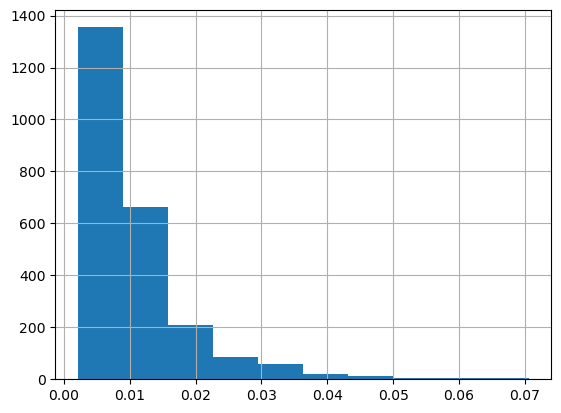

In [134]:
df['15min_range'] = df['High'].rolling(15).max() - df['Low'].rolling(15).min()
(df['15min_range'] /df['High']).hist()

In [135]:
def getDailyVol(data, span=30):
    df = data.assign(Return = lambda x: data['Close'] / data['Close'].shift(1)-1)
    sigma = df['Return'].ewm(span=span).std()
    return sigma

vol = getDailyVol(data=df)

In [136]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

events = df[['Timestamp']].copy(deep=True)
events['VB'] = df['Timestamp'] + pd.Timedelta(minutes=15)
events['Vol'] = vol

print(events)

               Timestamp                  VB       Vol
0    2023-07-07 09:26:00 2023-07-07 09:41:00       NaN
1    2023-07-07 09:31:00 2023-07-07 09:46:00       NaN
2    2023-07-07 09:32:00 2023-07-07 09:47:00  0.016934
3    2023-07-07 09:33:00 2023-07-07 09:48:00  0.012673
4    2023-07-07 09:34:00 2023-07-07 09:49:00  0.010223
...                  ...                 ...       ...
2427 2023-07-20 14:58:00 2023-07-20 15:13:00  0.001025
2428 2023-07-20 14:59:00 2023-07-20 15:14:00  0.000992
2429 2023-07-20 15:00:00 2023-07-20 15:15:00  0.000960
2430 2023-07-20 15:01:00 2023-07-20 15:16:00  0.000936
2431 2023-07-20 15:35:00 2023-07-20 15:50:00  0.000906

[2432 rows x 3 columns]


In [137]:
def TBL(df, events, width):
    
    res = events[['Timestamp', 'VB']].copy(deep=True)
    
    if width[0] > 0: events['UB'] = width[0]*events['Vol']
    else: events['UB'] = np.nan
        
    if width[1] > 0: events['DB'] = -width[1]*events['Vol']
    else: events['DB'] = np.nan
        
    for col,date,vb in res.itertuples():
        df0 = df[(df['Timestamp'] > date) & (df['Timestamp'] < vb)].copy(deep=True)
        df0['Return'] = df0['Close'] / df.loc[df['Timestamp'] == date, 'Close'].iloc[0]-1
        
        idx = (res['Timestamp'] == date)
        
        res.loc[idx, 'ut'] = df0.loc[df0['Return'] > events.loc[idx,'UB'].iloc[0], 'Timestamp'].min()
        res.loc[idx, 'dt'] = df0.loc[df0['Return'] < events.loc[idx,'DB'].iloc[0], 'Timestamp'].min()
            
    return res

In [138]:
def get_first_touch(df, events, width):
    res = TBL(df, events, width)
    res['First'] = res[['VB', 'ut', 'dt']].dropna(how='all').min(axis=1)
    return res

# 上下栅栏的宽度由 vol(span) * 系数[up,down] 决定
result = get_first_touch(df,events,width = [0.4,0.4])
print(result)

               Timestamp                  VB  ut                  dt  \
0    2023-07-07 09:26:00 2023-07-07 09:41:00 NaT                 NaT   
1    2023-07-07 09:31:00 2023-07-07 09:46:00 NaT                 NaT   
2    2023-07-07 09:32:00 2023-07-07 09:47:00 NaT 2023-07-07 09:34:00   
3    2023-07-07 09:33:00 2023-07-07 09:48:00 NaT 2023-07-07 09:34:00   
4    2023-07-07 09:34:00 2023-07-07 09:49:00 NaT 2023-07-07 09:35:00   
...                  ...                 ...  ..                 ...   
2427 2023-07-20 14:58:00 2023-07-20 15:13:00 NaT                 NaT   
2428 2023-07-20 14:59:00 2023-07-20 15:14:00 NaT                 NaT   
2429 2023-07-20 15:00:00 2023-07-20 15:15:00 NaT                 NaT   
2430 2023-07-20 15:01:00 2023-07-20 15:16:00 NaT                 NaT   
2431 2023-07-20 15:35:00 2023-07-20 15:50:00 NaT                 NaT   

                   First  
0    2023-07-07 09:41:00  
1    2023-07-07 09:46:00  
2    2023-07-07 09:34:00  
3    2023-07-07 09:34:00  


In [139]:
def get_label(df,result):
    result = result.dropna(subset=['First'])
    outcome = result[['Timestamp']].copy(deep=True)
    
    price_t0 = pd.merge(result,df,on=['Timestamp'],how='left')['Close']
    price_t1 = pd.merge(result,df,left_on=['First'], right_on=['Timestamp'], how = 'left')['Close']
    
    outcome['Return'] = price_t1/price_t0-1
    outcome['TB_15min_Label'] = np.sign(outcome['Return'].dropna())
    
    outcome = outcome.drop(['Return'], axis = 1)

    return outcome

outcome = get_label(df,result)
print(outcome)

df = pd.merge(df,outcome, on=['Timestamp'],how='inner')

               Timestamp  TB_15min_Label
0    2023-07-07 09:26:00            -1.0
1    2023-07-07 09:31:00            -1.0
2    2023-07-07 09:32:00            -1.0
3    2023-07-07 09:33:00            -1.0
4    2023-07-07 09:34:00            -1.0
...                  ...             ...
2427 2023-07-20 14:58:00             NaN
2428 2023-07-20 14:59:00             NaN
2429 2023-07-20 15:00:00             NaN
2430 2023-07-20 15:01:00             NaN
2431 2023-07-20 15:35:00             NaN

[2432 rows x 2 columns]


Cleaning NaN and unwanted data

In [140]:
print('Number of rows before cleaning: %d'%df.shape[0])

df.index = df['Timestamp']
df = df.drop(['Timestamp'], axis=1)

# df = df[(df['Target_Close_1min'] != 0)
#                       & (df['Target_Close_5min_Mean'] != 0)
#                       & (df['Target_Close_10min_Mean'] != 0)
#                       & (df['Target_Close_15min_Mean'] != 0)
#                      ]
# pd.set_option ('mode.use_inf_as_na', True)
# df = df.dropna()


print('Number of rows after cleaning: %d'%df.shape[0])

print(df)

Number of rows before cleaning: 2432
Number of rows after cleaning: 2432
                        Open     High      Low    Volume     Turnover  \
Timestamp                                                               
2023-07-07 09:26:00  307.000  307.000  307.000   25540.0   7840780.00   
2023-07-07 09:31:00  307.000  307.000  300.054  147350.0  44929827.97   
2023-07-07 09:32:00  299.001  302.459  299.001   72650.0  21905618.55   
2023-07-07 09:33:00  301.125  301.125  297.473   83310.0  24915514.67   
2023-07-07 09:34:00  300.584  300.617  296.995   71470.0  21314935.10   
...                      ...      ...      ...       ...          ...   
2023-07-20 14:58:00  260.500  260.500  260.500     220.0     57310.00   
2023-07-20 14:59:00  260.500  260.500  260.500       0.0         0.00   
2023-07-20 15:00:00  260.500  260.500  260.500       0.0         0.00   
2023-07-20 15:01:00  260.600  260.600  260.600    9770.0   2546062.00   
2023-07-20 15:35:00  260.600  260.600  260.600     

Saving CSV

In [141]:
df.to_csv(PATH_WRITE)